# Исследование надежности заемщиков.

<div style="border:solid Chocolate 2px; padding: 40px">

Заказчик — кредитный отдел банка. Нужно разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. Входные данные от банка — статистика о платёжеспособности клиентов.
    
Результаты исследования будут учтены при построении модели кредитного скоринга — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

## Обзор данных

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv ('/datasets/data.csv')
data.to_csv('sprint4.csv', index=False)

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


<div class="alert alert-info"> <b>Комментарий:</b> Видим некоторые количество проблем. Пропуски, неправильные форматы и прочее. Поработаем с этим. </div>

## Предобработка данных

### Удаление пропусков

In [4]:
#посчитаем пропуски
data.isna().sum()

children               0
days_employed       2174
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2174
purpose                0
dtype: int64

<div class="alert alert-info"> <b>Комментарий:</b> В двух столбцах есть пропущенные значения. Один из них — days_employed. Пропуски в этом столбце мы обработаем на следующем этапе. Другой столбец с пропущенными значениями — total_income — хранит данные о доходах. На сумму дохода сильнее всего влияет тип занятости, поэтому заполнить пропуски в этом столбце нужно медианным значением по каждому типу из столбца income_type. Например, у человека с типом занятости сотрудник пропуск в столбце total_income должен быть заполнен медианным доходом среди всех записей с тем же типом. </div>

In [5]:
for t in data['income_type'].unique():
    data.loc[(data['income_type'] == t) & (data['total_income'].isna()), 'total_income'] = \
    data.loc[(data['income_type'] == t), 'total_income'].median()

### Обработка аномальных значений

<div class="alert alert-info"> <b>Комментарий:</b> В данных есть несколько странных значений. Например, отрицательные значения. Уберем их. </div>

In [6]:
data['days_employed'] = data['days_employed'].abs()

<div class="alert alert-info"> <b>Комментарий:</b> Для каждого типа занятости покажем медианное значение трудового стажа `days_employed` в днях. </div>

In [7]:
data.groupby('income_type')['days_employed'].agg('median')

income_type
безработный        366413.652744
в декрете            3296.759962
госслужащий          2689.368353
компаньон            1547.382223
пенсионер          365213.306266
предприниматель       520.848083
сотрудник            1574.202821
студент               578.751554
Name: days_employed, dtype: float64

<div class="alert alert-info"> <b>Комментарий:</b> У двух типов (безработные и пенсионеры) получатся аномально большие значения. Исправить такие значения сложно, поэтому оставим их как есть. Тем более этот столбец не понадобится нам для исследования. </div>

<div class="alert alert-info"> <b>Комментарий:</b> Посмотрим на уникальные значения количества детей</div>

In [8]:
data['children'].unique()

array([ 1,  0,  3,  2, -1,  4, 20,  5])

<div class="alert alert-info"> <b>Комментарий:</b> В столбце children есть два аномальных значения. Удалим строки, в которых встречаются такие аномальные значения из датафрейма. </div>

In [9]:
data = data[(data['children'] != -1) & (data['children'] != 20)]
data['children'].unique()

array([1, 0, 3, 2, 4, 5])

<div class="alert alert-info"> <b>Комментарий:</b> Теперь все ок </div>

<div class="alert alert-info"> <b>Комментарий:</b> Заполним пропуски в столбце days_employed медианными значениями по каждого типа занятости income_type. </div>

In [10]:
for t in data['income_type'].unique():
    data.loc[(data['income_type'] == t) & (data['days_employed'].isna()), 'days_employed'] = \
    data.loc[(data['income_type'] == t), 'days_employed'].median()

In [11]:
data.isna().sum()

children            0
days_employed       0
dob_years           0
education           0
education_id        0
family_status       0
family_status_id    0
gender              0
income_type         0
debt                0
total_income        0
purpose             0
dtype: int64

<div class="alert alert-info"> <b>Комментарий:</b> Теперь в нашем фрейме нет пропусков. </div>

<div class="alert alert-info"> <b>Комментарий:</b> Заменим вещественный тип данных в столбце `total_income` </div>

In [12]:
data['total_income'] = data['total_income'].astype(int)

## Обработка дубликатов

<div class="alert alert-info"> <b>Комментарий:</b> В столбце education и family_status есть дубликаты из-за разного регистра. Исправим это. </div>

In [13]:
data['education'] = data['education'].str.lower()
data['family_status'] = data['family_status'].str.lower()

<div class="alert alert-info"> <b>Комментарий:</b> Посчитаем строки-дубликаты </div>

In [14]:
data.duplicated().sum()

71

In [15]:
#удаляем дубликаты
data = data.drop_duplicates()

## Категоризация данных

<div class="alert alert-info"> <b>Комментарий:</b> 
    
На основании диапазонов, указанных ниже, создадим в датафрейме столбец total_income_category с категориями:

- 0–30000 — `'E'`;
- 30001–50000 — `'D'`;
- 50001–200000 — `'C'`;
- 200001–1000000 — `'B'`;
- 1000001 и выше — `'A'`. 

</div>

In [16]:
def categorize_income(income):
    try:
        if 0 <= income <= 30000:
            return 'E'
        elif 30001 <= income <= 50000:
            return 'D'
        elif 50001 <= income <= 200000:
            return 'C'
        elif 200001 <= income <= 1000000:
            return 'B'
        elif income >= 1000001:
            return 'A'
    except:
        pass

In [17]:
data['total_income_category'] = data['total_income'].apply(categorize_income)

<div class="alert alert-info"> <b>Комментарий:</b> 
    
Выведим на экран перечень уникальных целей взятия кредита из столбца `'purpose'`.

</div>

In [18]:
data['purpose'].unique()

array(['покупка жилья', 'приобретение автомобиля',
       'дополнительное образование', 'сыграть свадьбу',
       'операции с жильем', 'образование', 'на проведение свадьбы',
       'покупка жилья для семьи', 'покупка недвижимости',
       'покупка коммерческой недвижимости', 'покупка жилой недвижимости',
       'строительство собственной недвижимости', 'недвижимость',
       'строительство недвижимости', 'на покупку подержанного автомобиля',
       'на покупку своего автомобиля',
       'операции с коммерческой недвижимостью',
       'строительство жилой недвижимости', 'жилье',
       'операции со своей недвижимостью', 'автомобили',
       'заняться образованием', 'сделка с подержанным автомобилем',
       'получение образования', 'автомобиль', 'свадьба',
       'получение дополнительного образования', 'покупка своего жилья',
       'операции с недвижимостью', 'получение высшего образования',
       'свой автомобиль', 'сделка с автомобилем',
       'профильное образование', 'высшее об

<div class="alert alert-info"> <b>Комментарий:</b> 
    
Создадим функцию, которая на основании данных из столбца `purpose` сформирует новый столбец `purpose_category`, в который войдут следующие категории:

- `'операции с автомобилем'`,
- `'операции с недвижимостью'`,
- `'проведение свадьбы'`,
- `'получение образования'`.

</div>

In [19]:
def categorize_purpose(row):
    try:
        if 'автом' in row:
            return 'операции с автомобилем'
        elif 'жил' in row or 'недвиж' in row:
            return 'операции с недвижимостью'
        elif 'свад' in row:
            return 'проведение свадьбы'
        elif 'образов' in row:
            return 'получение образования'
    except:
        return 'нет категории'

In [20]:
data['purpose_category'] = data['purpose'].apply(categorize_purpose)

## Ответы на вопросы.

### Какой общий процент задержек оплаты?

In [21]:
delay_payment = data[data['debt'] == 1].count() / data[data['debt'] == 0].count()*100
print ('{0:.2f}%'.format(delay_payment['debt']))

8.84%


### Есть ли зависимость между количеством детей и возвратом кредита в срок?

8.16% процент задержек у тех, у кого нет детей
10.17% процент задержек у тех, у кого 1 ребенок
10.44% процент задержек у тех, у кого 2 ребенка
8.91% процент задержек у тех, у кого 3 ребенка
10.81% процент задержек у тех, у кого 4 ребенка


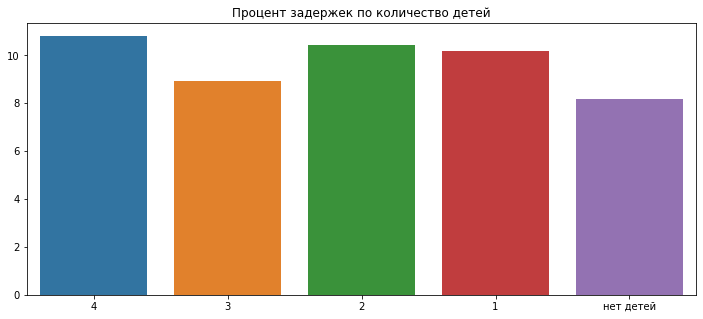

общий процент возврата кредита людей с детьми 10.08%


In [22]:
data_pivot1 = data.pivot_table(index=['debt'], columns='children', values = 'gender', aggfunc='count')


ch0 = data_pivot1[0][1] / data_pivot1[0][0]*100
ch1 = data_pivot1[1][1] / data_pivot1[1][0]*100
ch2 = data_pivot1[2][1] / data_pivot1[2][0]*100
ch3 = data_pivot1[3][1] / data_pivot1[3][0]*100
ch4 = data_pivot1[4][1] / data_pivot1[4][0]*100
with_child = (ch1+ch2+ch3+ch4)/4

print("{0:.2f}% процент задержек у тех, у кого нет детей".format(ch0))
print("{0:.2f}% процент задержек у тех, у кого 1 ребенок".format(ch1))
print("{0:.2f}% процент задержек у тех, у кого 2 ребенка".format(ch2))
print("{0:.2f}% процент задержек у тех, у кого 3 ребенка".format(ch3))
print("{0:.2f}% процент задержек у тех, у кого 4 ребенка".format(ch4))

y_ch=[ ch4, ch3, ch2, ch1, ch0]
x_ch = [4, 3, 2, 1, 'нет детей']

plt.figure(figsize=(12,5))
sns.barplot(x = x_ch, y=y_ch)
plt.title('Процент задержек по количество детей')
plt.show()




print ('общий процент возврата кредита людей с детьми', '{0:.2f}%'.format(with_child))


<div class="alert alert-info"> <b>Комментарий:</b> 
    
В целом наличие детей увеличивает процент задержек. При этом клиенты без детей чаще вовзращаю кредит в срок по сравнению с общим процентом задержек по всем клиентам

</div>

### Есть ли зависимость между семейным положением и возвратом кредита в срок?

7.60% в разводе
7.09% вдовец / вдова
10.27% гражданский брак
8.18% женат / замужем
10.82% не женат / не замужем
10.54% процент среди одиноких и гражданский брак
7.63% процент среди остальных групп


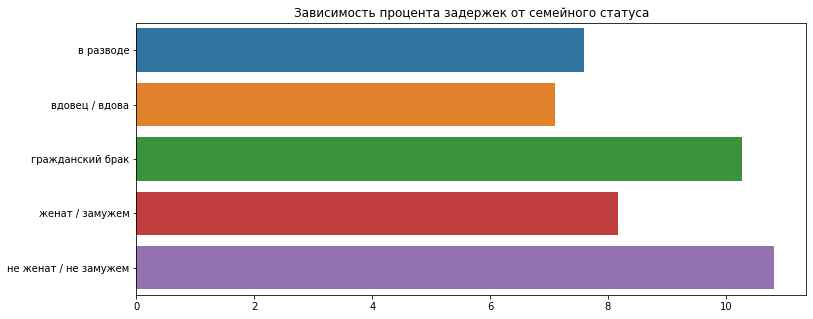

In [28]:

data_pivot2 = data.pivot_table(index=['debt'], columns='family_status', values='children', aggfunc='count')
single = data_pivot2['не женат / не замужем'][1] / data_pivot2['не женат / не замужем'][0]*100
divorced = data_pivot2['в разводе'][1] / data_pivot2['в разводе'][0]*100
widowed = data_pivot2['вдовец / вдова'][1] / data_pivot2['вдовец / вдова'][0]*100
civil_marriage = data_pivot2['гражданский брак'][1] / data_pivot2['гражданский брак'][0]*100
married = data_pivot2['женат / замужем'][1] / data_pivot2['женат / замужем'][0]*100

single_and_civil_marriage = (single+civil_marriage)/2
others = (divorced+widowed+married)/3

print("{0:.2f}% в разводе".format(divorced))
print("{0:.2f}% вдовец / вдова".format(widowed))
print("{0:.2f}% гражданский брак".format(civil_marriage))
print("{0:.2f}% женат / замужем".format(married))
print("{0:.2f}% не женат / не замужем".format(single))
print("{0:.2f}% процент среди одиноких и гражданский брак".format(single_and_civil_marriage))
print("{0:.2f}% процент среди остальных групп".format(others))


x_status = [ divorced, widowed, civil_marriage, married, single]
y_status = sorted(data['family_status'].unique())

plt.figure(figsize=(12,5))
sns.barplot(x = x_status, y=y_status)
plt.title('Зависимость процента задержек от семейного статуса')
plt.show()

<div class="alert alert-info"> <b>Комментарий:</b> 
    
Семейный статус сильно влияет на процент воврата кредита в срок. Чаще всех задерживают одинокие люди. При этом те, кто разведен или является вдовой/вдовцом чаще всех возвращают кредиты в срок. 

</div>

###  Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

8.70% задержек катеории А
7.60% задержек катеории B
9.29% задержек катеории C
6.40% задержек катеории D
10.00% задержек катеории E


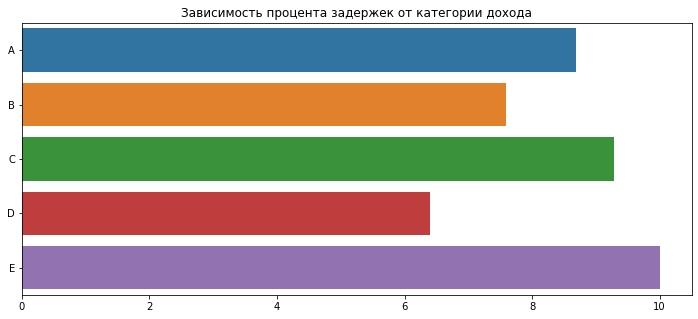

In [31]:
data_pivot3 = data.pivot_table(index=['debt'], columns='total_income_category', values='children', aggfunc='count')
cat_a = data_pivot3['A'][1]/data_pivot3['A'][0]*100
cat_b = data_pivot3['B'][1]/data_pivot3['B'][0]*100
cat_c = data_pivot3['C'][1]/data_pivot3['C'][0]*100
cat_d = data_pivot3['D'][1]/data_pivot3['D'][0]*100
cat_e = data_pivot3['E'][1]/data_pivot3['E'][0]*100

print("{0:.2f}% задержек катеории А".format(cat_a))
print("{0:.2f}% задержек катеории B".format(cat_b))
print("{0:.2f}% задержек катеории C".format(cat_c))
print("{0:.2f}% задержек катеории D".format(cat_d))
print("{0:.2f}% задержек катеории E".format(cat_e))

x_cat = [cat_a, cat_b, cat_c, cat_d, cat_e,]
y_cat = sorted(data['total_income_category'].unique())

plt.figure(figsize=(12,5))
sns.barplot(x=x_cat, y=y_cat)
plt.title('Зависимость процента задержек от категории дохода')
plt.show()

<div class="alert alert-info"> <b>Комментарий:</b> 
    
Люди с наименьшим доходом чаще всех задерживают выплаты. Однако на удивление выяснилось, что уровень достатка сильно не вляиет на возврат кредита в срок. Категории А, В и С задерживают выплату гораздо чаще, чем категория D.

</div>

### Как разные цели кредита влияют на его возврат в срок?

10.31% задержек в целях по операциям с автомобилями
7.82% задержек в целях по операция с недвижимостью
10.20% задержек в целях по получени образования
8.59% задержек в целях по проведению свадьбы


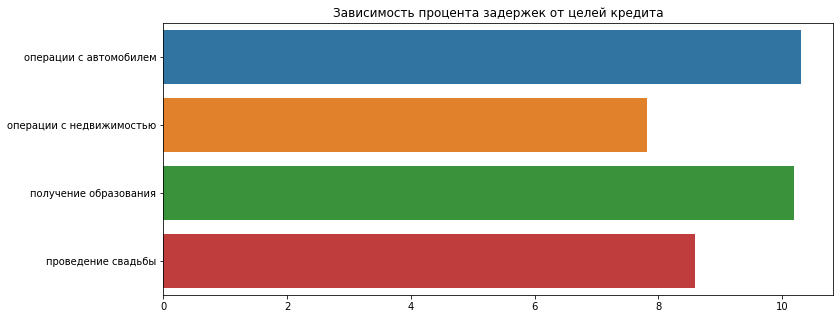

In [36]:
data_pivot4 = data.pivot_table(index=['debt'], columns='purpose_category', values='children', aggfunc='count')
transport = data_pivot4['операции с автомобилем'][1]/data_pivot4['операции с автомобилем'][0]*100
estate = data_pivot4['операции с недвижимостью'][1]/data_pivot4['операции с недвижимостью'][0]*100
education = data_pivot4['получение образования'][1]/data_pivot4['получение образования'][0]*100
marriage = data_pivot4['проведение свадьбы'][1]/data_pivot4['проведение свадьбы'][0]*100

print("{0:.2f}% задержек в целях по операциям с автомобилями".format(transport))
print("{0:.2f}% задержек в целях по операция с недвижимостью".format(estate))
print("{0:.2f}% задержек в целях по получени образования".format(education))
print("{0:.2f}% задержек в целях по проведению свадьбы".format(marriage))


x = [transport, estate, education, marriage]
y = sorted(data['purpose_category'].unique())


plt.figure(figsize=(12,5))
sns.barplot (x=x, y=y)
plt.title('Зависимость процента задержек от целей кредита')
plt.show()

<div class="alert alert-info"> <b>Комментарий:</b> 
    
Кредыты, взятые на недвижимость и свадьбу, возвращают в срок чаще, чем кредиты на транспорт и образование

</div>

## Общий вывод:

**Общие выводы**
<div style="border-radius: 15px; box-shadow: 2px 2px 4px; border: 1px solid; background:Gainsboro; padding: 20px">

Проведена предобработка таблицы. Пропущенные значения в столбцах total_income и days_employed заполнены медианными занчениями, таблица приведена в один регистр, убраны дубликаты. Сделана категоризация доходов клиентов и целей кредитов. После предобработки в данных осталость 21452 строк - количество, достаточное для продолжения исследования.

</div>




<div style="border-radius: 15px; box-shadow: 2px 2px 4px; border: 1px solid; background:Gainsboro; padding: 20px">

- Есть ли зависимость между количеством детей и возвратом кредита в срок? 
    
Семейный статус и количество детей заметно вляет на процент задержек по кредиту. Процент задержек среди тех, у кого есть дети составляет 10,08%. Среди тех, у кого нет детей - 8,16%. При этом отдельно нужно отметить, что процент задержек среди тех, у кого ТРИ ребенка, не сильно выше по сравнению с  группой людей без детей и по сравнению с общим процентом задержек, который составляет 8,83%
</div>


<div style="border-radius: 15px; box-shadow: 2px 2px 4px; border: 1px solid; background:Gainsboro; padding: 20px">

- Есть ли зависимость между семейным положением и возвратом кредита в срок? 
    
Семейное положение влияет на вероятность возврата кредита в срок. Процент задержек среди одиноких и людей в гражданском браке сильно выше - 10.56%. Общий процент задержек по осташимся группам - 7.62%

</div>

<div class="alert alert-info"> <b> Идеальный клиент - вдова без детей, с низким доходом, берущая кредит на недвижимость :))  Непростая у нее жизнь, однако </b> </div>